In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.time import Time

In [2]:
import rubin_sim.site_models as site_models

In [3]:
start_date = Time('2025-07-01T00:00:00', format='isot')

In [4]:
almanac = site_models.Almanac(start_date.mjd)

In [5]:
almanac.sunsets

array([(-2099, 58757.94473027, 58757.98369131, 58758.00351628, 58758.37471194, 58758.3945249 , 58758.43345442, 58758.55614333, 58758.08643426),
       (-2098, 58758.94514084, 58758.98414289, 58759.00400721, 58759.37378333, 58759.39363542, 58759.43260561, 58759.58757186, 58759.13087673),
       (-2097, 58759.94555308, 58759.98459992, 58760.0045051 , 58760.37285153, 58760.39274407, 58760.43176072, 58760.62110521, 58760.17324347),
       ...,
       ( 7030, 67886.94392365, 67886.98280602, 67887.00255531, 67887.37663219, 67887.39636784, 67887.43521639, 67887.66625326, 67887.2433917 ),
       ( 7031, 67887.94432525, 67887.98324487, 67888.00303039, 67888.37569925, 67888.39547229, 67888.43435956, 67888.70580155, 67888.27415344),
       ( 7032, 67888.94473028, 67888.98368886, 67889.00351213, 67889.37476771, 67889.39457898, 67889.43350667, 67889.74589796, 67889.30118906)],
      dtype=[('night', '<i8'), ('sunset', '<f8'), ('sun_n12_setting', '<f8'), ('sun_n18_setting', '<f8'), ('sun_n18_rising'

In [6]:
eve_twi_time = almanac.sunsets['sun_n18_setting'] - almanac.sunsets['sun_n12_setting']
morn_twi_time = almanac.sunsets['sun_n12_rising'] - almanac.sunsets['sun_n18_rising']

27.764550000429153 27.765685245394707
35.9772527217865 35.97283914685249


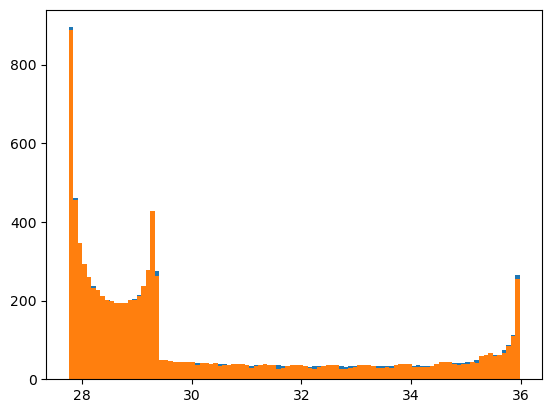

In [7]:
n,b,p = plt.hist(eve_twi_time * 60 * 24, bins=100)
n,b,p = plt.hist(morn_twi_time * 60 * 24, bins=100)
print(morn_twi_time.min()*60*24, eve_twi_time.min()*60*24)
print(morn_twi_time.max()*60*24, eve_twi_time.max()*60*24)

In [8]:
import sqlite3 
import pandas as pd

conn = sqlite3.connect('fbs_3.2/baseline_v3.2_10yrs.db')
query = "select * from observations"
visitsDf = pd.read_sql(query, conn)

In [9]:
twi_visits = visitsDf.query('note.str.startswith("twilight")')

In [10]:
from rubin_sim.maf import HourAngleStacker

haStacker = HourAngleStacker()
twi_visits_ha = haStacker.run(twi_visits.to_records())
twi_visits_ha = pd.DataFrame(twi_visits_ha)

In [11]:
twi_visits_eve = twi_visits_ha.query('HA > 0')
twi_visits_morn = twi_visits_ha.query('HA < 0')

In [12]:
eve_twi_len = twi_visits_eve.groupby('night')['observationStartMJD'].max()  - twi_visits_eve.groupby('night')['observationStartMJD'].min() 
morn_twi_len = twi_visits_morn.groupby('night')['observationStartMJD'].max()  - twi_visits_morn.groupby('night')['observationStartMJD'].min() 

27.764550000429153 27.765685245394707
35.9772527217865 35.97283914685249
0.8999999903608114 0.8999999903608114
21.60798186552711 31.875005319016054


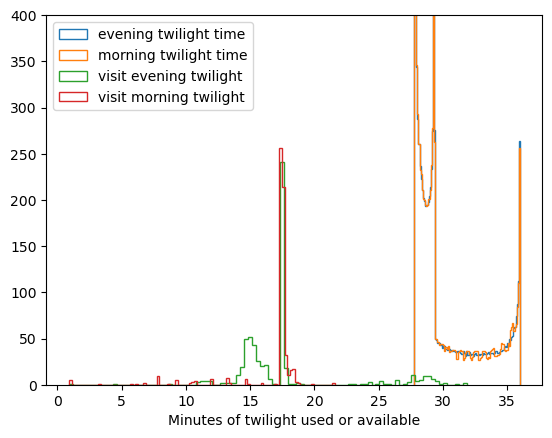

In [13]:
n,b,p = plt.hist(eve_twi_time * 60 * 24, bins=100, label='evening twilight time', alpha=1, histtype='step')
n,b,p = plt.hist(morn_twi_time * 60 * 24, bins=100, label='morning twilight time', alpha=1, histtype='step')
print(morn_twi_time.min()*60*24, eve_twi_time.min()*60*24)
print(morn_twi_time.max()*60*24, eve_twi_time.max()*60*24)
n,b,p = plt.hist(eve_twi_len * 60 * 24, bins=100, label='visit evening twilight', alpha=1, histtype='step')
n,b,p = plt.hist(morn_twi_len * 60 * 24, bins=100, label='visit morning twilight', alpha=1, histtype='step')
plt.legend()
plt.ylim(0, 400)
plt.xlabel("Minutes of twilight used or available")
print(morn_twi_len.min()*60*24, eve_twi_len.min()*60*24)
print(morn_twi_len.max()*60*24, eve_twi_len.max()*60*24)

In [14]:
from rubin_sim.scheduler.basis_functions import BaseBasisFunction

class SunHighLimitBasisFunction(BaseBasisFunction):
     """Only execute if the sun is high. Have a sum alt limit for sunset, and a time
     until 12 degree twilight for sun rise.
     Parameters
     ----------
     sun_alt_limit : `float`
         The sun altitude limit (degrees). Sun must be higher than this at sunset to execute
     """

     def __init__(self, sun_alt_limit=-14.8, time_to_12deg=21.0, time_remaining=15.0):
         super().__init__()
         self.sun_alt_limit = np.radians(sun_alt_limit)
         self.time_to_12deg = time_to_12deg / 60.0 / 24.0
         self.time_remaining = time_remaining / 60.0 / 24.0

     def check_feasibility(self, conditions):
         result = False

         # If the sun is high, it's ok to execute
         if conditions.sun_alt > self.sun_alt_limit:
             result = True
         time_left = conditions.sun_n12_rising - conditions.mjd
         if time_left < self.time_to_12deg:
             result = True
         if time_left < self.time_remaining:
             result = False
         return result

In [15]:
sunset = almanac.sunsets['sun_n12_setting'][0]
sunrise = almanac.sunsets['sun_n12_rising'][0]

mjd = np.arange(58757.8, 58758.5, 0.1)
sunrise - mjd

array([ 0.5945249,  0.4945249,  0.3945249,  0.2945249,  0.1945249,
        0.0945249, -0.0054751])

In [16]:
class TwilightTimeBasisFunction(BaseBasisFunction):
     """Only execute within a fraction of the time between sun altitude -18 and -12, 
     if there is at least some time available.
     
     Parameters
     ----------
     min_time : `float`, opt
         Minimum time required before 12 degree sunrise, in minutes.
     max_fraction: `float`, opt
         Maximum fraction of time between -12 and -18 degree sunrise/sunset to use.


     Note
     ----
     This feasibility function will not cut off due to sunrise or sunset. Handle that possibility elsewhere.
     (although, min_time will effectively provide a cutoff at -12 deg sunrise unless negative numbers are used). 
     If less than the minimum amount of time is left until sunrise, this feasibility function will return False,
     so this assumes that the sequence of visits is started and this function is not called again. 
     """

     def __init__(self, min_time=15.0, max_fraction=0.7):
         super().__init__()
         self.min_time = min_time / 60.0 / 24.0
         self.max_fraction = max_fraction

     def check_feasibility(self, conditions):
         # Note that this feasibility check will NOT cut off due to sunrise
         # Handle this elsewhere 

         valid = False
         # What is the appropriate amount of time to use for TwilightTime? 
         twilight_available = (conditions.sun_n12_rising - conditions.sun_n18_rising) * self.max_fraction

         # Is the current time earlier than n_12_setting + time available? 
         dt_eve = conditions.mjd - conditions.sun_n12_setting
         if dt_eve <= twilight_available:
             valid = True

         # Is the current time later than n_12 rise + time available?  And is there at least min_time left?
         dt_morn = conditions.sun_n12_rising - conditions.mjd
         if dt_morn <= twilight_available and dt_morn >= self.min_time: 
             valid = True

         return valid

In [17]:
from rubin_sim.scheduler.features import Conditions

In [32]:
tt_basis = TwilightTimeBasisFunction(min_time=15, max_fraction=0.7)
sa_basis = SunHighLimitBasisFunction(sun_alt_limit=-16.5, time_to_12deg=21.0, time_remaining=15.0)
conditions = Conditions()

mjds = np.arange(58757.9, 58758.45, 30/60/60/24.)
tt = []
sa = []
sunalt = []
for mjd in mjds:
    conditions.mjd = mjd
    conditions.sunset = almanac.sunsets["sunset"][0]
    conditions.sun_n12_setting = almanac.sunsets['sun_n12_setting'][0]
    conditions.sun_n12_rising = almanac.sunsets['sun_n12_rising'][0]
    conditions.sun_n18_setting = almanac.sunsets['sun_n18_setting'][0]
    conditions.sun_n18_rising = almanac.sunsets['sun_n18_rising'][0]
    sun_moon_info = almanac.get_sun_moon_positions(mjd)
    conditions.sun_alt = sun_moon_info["sun_alt"]
    sunalt.append(sun_moon_info["sun_alt"])
    tt.append(tt_basis.check_feasibility(conditions))
    sa.append(sa_basis.check_feasibility(conditions))

sunalt = np.array(sunalt)
tt = np.array(tt)
sa = np.array(sa)

Text(0, 0.5, 'Sun altitude (deg) + feasibility')

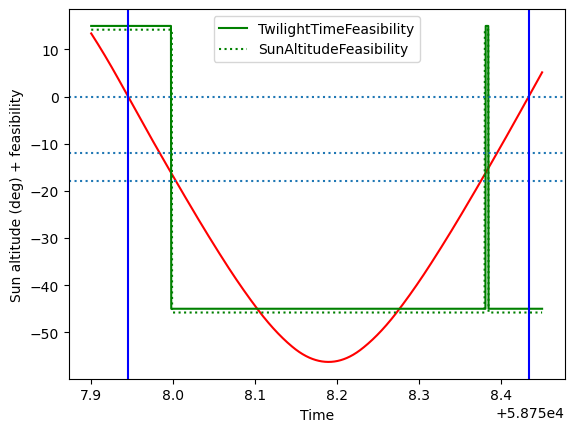

In [33]:
plt.plot(mjds, np.degrees(sunalt), color='r')
feasible = np.zeros(len(mjds)) - 45
feasible[tt] += 60
plt.plot(mjds, feasible, color='g', label="TwilightTimeFeasibility")
feasible = np.zeros(len(mjds)) - 45.8
feasible[sa] += 60
plt.plot(mjds, feasible, color='g', linestyle=':', label="SunAltitudeFeasibility")
plt.axhline(-18, linestyle=':')
plt.axhline(-12, linestyle=':')
plt.axhline(0, linestyle=':')
plt.legend()
plt.axvline(almanac.sunsets['sunset'][0], color='b')
plt.axvline(almanac.sunsets['sunrise'][0], color='b')
plt.xlabel("Time")
plt.ylabel("Sun altitude (deg) + feasibility")

In [34]:
# Time feasible and with sun below -12 degrees
(mjds[np.where(mjds[tt] < 58758.2)].max() - almanac.sunsets['sun_n12_setting'][0]) * 60 * 24

19.48452002950944

Text(0, 0.5, 'Sun altitude (deg) + feasibility')

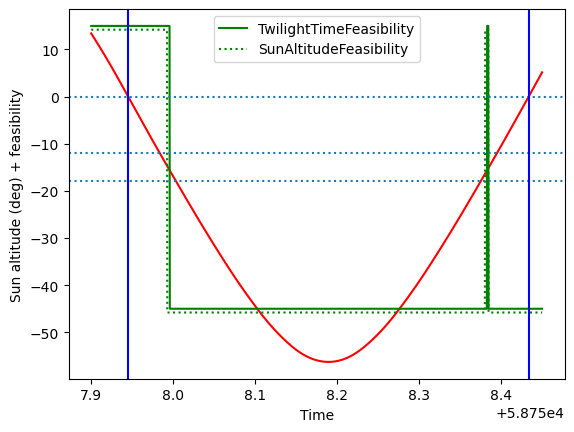

In [38]:
tt_basis = TwilightTimeBasisFunction(min_time=15, max_fraction=0.6)
sa_basis = SunHighLimitBasisFunction(sun_alt_limit=-14.7, time_to_12deg=21.0, time_remaining=15.0)
conditions = Conditions()

mjds = np.arange(58757.9, 58758.45, 30/60/60/24.)
tt = []
sa = []
sunalt = []
for mjd in mjds:
    conditions.mjd = mjd
    conditions.sunset = almanac.sunsets["sunset"][0]
    conditions.sun_n12_setting = almanac.sunsets['sun_n12_setting'][0]
    conditions.sun_n12_rising = almanac.sunsets['sun_n12_rising'][0]
    conditions.sun_n18_setting = almanac.sunsets['sun_n18_setting'][0]
    conditions.sun_n18_rising = almanac.sunsets['sun_n18_rising'][0]
    sun_moon_info = almanac.get_sun_moon_positions(mjd)
    conditions.sun_alt = sun_moon_info["sun_alt"]
    sunalt.append(sun_moon_info["sun_alt"])
    tt.append(tt_basis.check_feasibility(conditions))
    sa.append(sa_basis.check_feasibility(conditions))

sunalt = np.array(sunalt)
tt = np.array(tt)
sa = np.array(sa)

plt.plot(mjds, np.degrees(sunalt), color='r')
feasible = np.zeros(len(mjds)) - 45
feasible[tt] += 60
plt.plot(mjds, feasible, color='g', label="TwilightTimeFeasibility")
feasible = np.zeros(len(mjds)) - 45.8
feasible[sa] += 60
plt.plot(mjds, feasible, color='g', linestyle=':', label="SunAltitudeFeasibility")
plt.axhline(-18, linestyle=':')
plt.axhline(-12, linestyle=':')
plt.axhline(0, linestyle=':')
plt.legend()
plt.axvline(almanac.sunsets['sunset'][0], color='b')
plt.axvline(almanac.sunsets['sunrise'][0], color='b')
plt.xlabel("Time")
plt.ylabel("Sun altitude (deg) + feasibility")